# A verb's usage-based meaning

Can we learn when to use the verb **start** and when to use the verb **begin** from exposure to examples?

- The movie `_________` at 7:30pm.
- The car wouldn't `_________`.
- My grandfather `_________` his company in 1927.
- The meeting `_________` at 9am.
- We should `_________` early, before traffic gets busy.
- The day `_________` well.


In [1]:
from itertools import chain         # embedded list to chain of lists
from itertools import repeat        # repeating element(s) in a list
from collections import Counter     # count unique items
from scipy.sparse import dok_matrix # sparse logical (binary) matrix
import numpy as np
import pandas as pd

In [2]:
semantic = pd.read_csv('../data/semantic_example.csv')
semantic.head()

,Cues,Outcomes
0,commence_journey,START
1,commence_machine,START
2,commence_movie,START
3,commence_movie,START
4,commence_meeting,BEGIN


In [3]:
semantic = semantic.applymap(lambda x : x.split('_'))
semantic.head()

,Cues,Outcomes
0,"[commence, journey]",[START]
1,"[commence, machine]",[START]
2,"[commence, movie]",[START]
3,"[commence, movie]",[START]
4,"[commence, meeting]",[BEGIN]


In [4]:
Counter(chain.from_iterable(semantic['Cues'].to_list()))

Counter({'commence': 81,
         'journey': 2,
         'machine': 11,
         'movie': 29,
         'meeting': 26,
         'day': 11,
         'business': 2})

In [5]:
all_cues = list(Counter(chain.from_iterable(semantic['Cues'].to_list())).keys())
all_cues

['commence', 'journey', 'machine', 'movie', 'meeting', 'day', 'business']

In [6]:
Counter(chain.from_iterable(semantic['Outcomes'].to_list()))

Counter({'START': 46, 'BEGIN': 35})

In [7]:
all_outcomes = list(Counter(chain.from_iterable(semantic['Outcomes'].to_list())).keys())
all_outcomes

['START', 'BEGIN']

In [8]:
num_events = len(semantic.index)
num_cues = len(all_cues)
num_outcomes = len(all_outcomes)

In [9]:
cue_matrix = dok_matrix((num_events, num_cues), dtype=bool)
outcome_matrix = dok_matrix((num_events, num_outcomes), dtype=bool)

In [10]:
for idx, row in semantic.iterrows():
	for cue in row['Cues']:
		cue_index = all_cues.index(cue)
		cue_matrix[idx, cue_index] = True
	for outcome in row['Outcomes']:
		outcome_index = all_outcomes.index(outcome)
		outcome_matrix[idx, outcome_index] = True

In [11]:
cue_nhot_matrix = pd.DataFrame(cue_matrix.todense().tolist(),
	columns=all_cues, dtype=int)
outcome_nhot_matrix = pd.DataFrame(outcome_matrix.todense().tolist(),
	columns=all_outcomes, dtype=int)

In [12]:
pd.concat([cue_nhot_matrix.reset_index(drop=True), outcome_nhot_matrix], axis=1).head()

,commence,journey,machine,movie,meeting,day,business,START,BEGIN
0,1,1,0,0,0,0,0,1,0
1,1,0,1,0,0,0,0,1,0
2,1,0,0,1,0,0,0,1,0
3,1,0,0,1,0,0,0,1,0
4,1,0,0,0,1,0,0,0,1


$$ \Delta w_{i} = \gamma  \times x_{i}^{T} \times (t - y_{in}) $$

In [13]:
def update_weights(cues, outcomes, old_weights, learning_rate):
	"""
	Updating weights for Widrow-Hoff / Delta / Least Mean Square (LMS) Rule
	----------
	cues          : input learning cues
	outcomes      : outcomes (targets, criteria)
	old_weights   : old weight values (in previous time step of learning)
	learning_rate : rate of learning (speed of change)
	"""
	new_weights = old_weights + (learning_rate * cues.T * (outcomes - (cues * old_weights)))
	return(new_weights)

In [14]:
weight_matrix = np.zeros((num_cues, num_outcomes))

In [15]:
for idx in range(num_events):
	current_cues = np.matrix(cue_nhot_matrix.iloc[idx,])
	current_outcomes = np.matrix(outcome_nhot_matrix.iloc[idx,])
	weight_matrix = update_weights(
		cues=current_cues,
		outcomes=current_outcomes,
		old_weights=weight_matrix,
		learning_rate = 0.01)

In [16]:
pd.DataFrame(weight_matrix, index=all_cues, columns=all_outcomes)

,START,BEGIN
commence,0.303431,0.206818
journey,0.017039,-0.002023
machine,0.090921,-0.014076
movie,0.124855,0.048227
meeting,0.038327,0.114798
day,0.017899,0.063794
business,0.014390,-0.003903


- - -
- - -

## Plotting

Below is a variant that allows you to keep the record of all updates and to visualize the process of learning (developing associations as the data accrues).

In [17]:
weight_matrix_2 = np.zeros((num_cues, num_outcomes))
weight_matrix_list = list()

In [18]:
for idx in range(num_events):
	current_cues = np.matrix(cue_nhot_matrix.iloc[idx,])
	current_outcomes = np.matrix(outcome_nhot_matrix.iloc[idx,])
	weight_matrix_2 = update_weights(
		cues=current_cues,
		outcomes=current_outcomes,
		old_weights=weight_matrix_2,
		learning_rate = 0.01)
	weight_matrix_list.append(weight_matrix_2.T.flatten().tolist()[0]) # keeping track of updates

In [19]:
data = {
    'Trial'    : [x+1 for x in range(num_events) for _ in range(num_cues * num_outcomes)],
    'Cues'     : all_cues * (num_outcomes * num_events),
    'Outcomes' : ([all_outcomes[0]] * num_cues + [all_outcomes[1]] * num_cues) * num_events,
    'Weights'  : list(chain(*weight_matrix_list))
}
sim01 = pd.DataFrame(data)
sim01.tail(14)

,Trial,Cues,Outcomes,Weights
1120,81,commence,START,0.303431
1121,81,journey,START,0.017039
1122,81,machine,START,0.090921
1123,81,movie,START,0.124855
1124,81,meeting,START,0.038327
1125,81,day,START,0.017899
1126,81,business,START,0.014390
1127,81,commence,BEGIN,0.206818
1128,81,journey,BEGIN,-0.002023
1129,81,machine,BEGIN,-0.014076


In [20]:
pd.DataFrame(weight_matrix, index=all_cues, columns=all_outcomes)

,START,BEGIN
commence,0.303431,0.206818
journey,0.017039,-0.002023
machine,0.090921,-0.014076
movie,0.124855,0.048227
meeting,0.038327,0.114798
day,0.017899,0.063794
business,0.014390,-0.003903


### Using the Python version of ggplot

In [21]:
start = sim01[sim01['Outcomes'] == 'START']

In [22]:
# import library for plotting
# INSTALLATION
# [1] conda install -c conda-forge plotnine
# [2] pip install plotnine
from plotnine import *

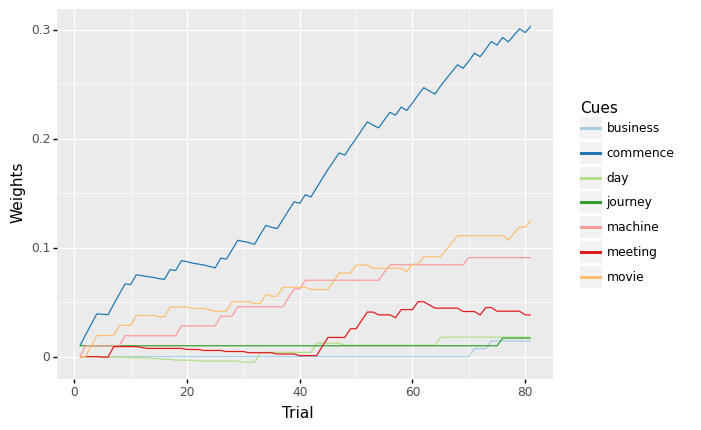

<ggplot: (8767677297713)>

In [23]:
(ggplot(start, aes(x='Trial', y='Weights', colour='Cues')) +
	geom_line() +
	scale_colour_manual(values=['#a6cee3', '#1f78b4',
		'#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f']))

### Using Python's matplotlib

In [24]:
import matplotlib.pyplot as plt

In [25]:
weights_df = pd.DataFrame(weight_matrix_list, columns=[i+'_'+j for i in all_outcomes for j in all_cues])
weights_df['Trial'] = np.arange(1, num_events+1, 1)
weights_df

,START_commence,START_journey,START_machine,START_movie,START_meeting,START_day,START_business,BEGIN_commence,BEGIN_journey,BEGIN_machine,BEGIN_movie,BEGIN_meeting,BEGIN_day,BEGIN_business,Trial
0,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.019900,0.010000,0.009900,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
2,0.029701,0.010000,0.009900,0.009801,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
3,0.039306,0.010000,0.009900,0.019406,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
4,0.038913,0.010000,0.009900,0.019406,-0.000393,0.000000,0.00000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.289069,0.017039,0.090921,0.107064,0.041754,0.017899,0.01439,0.207748,-0.002023,-0.014076,0.056053,0.107902,0.063794,-0.003903,77
77,0.295108,0.017039,0.090921,0.113103,0.041754,0.017899,0.01439,0.205110,-0.002023,-0.014076,0.053415,0.107902,0.063794,-0.003903,78
78,0.301025,0.017039,0.090921,0.119021,0.041754,0.017899,0.01439,0.202525,-0.002023,-0.014076,0.050830,0.107902,0.063794,-0.003903,79
79,0.297598,0.017039,0.090921,0.119021,0.038327,0.017899,0.01439,0.209420,-0.002023,-0.014076,0.050830,0.114798,0.063794,-0.003903,80


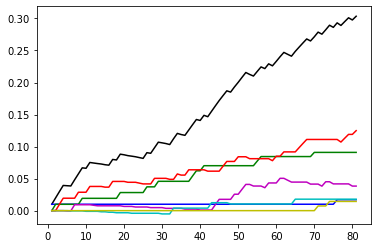

In [26]:
plt.plot(weights_df['Trial'], weights_df.iloc[:,[0]], '-k')
plt.plot(weights_df['Trial'], weights_df.iloc[:,[1]], '-b')
plt.plot(weights_df['Trial'], weights_df.iloc[:,[2]], '-g')
plt.plot(weights_df['Trial'], weights_df.iloc[:,[3]], '-r')
plt.plot(weights_df['Trial'], weights_df.iloc[:,[4]], '-m')
plt.plot(weights_df['Trial'], weights_df.iloc[:,[5]], '-c')
plt.plot(weights_df['Trial'], weights_df.iloc[:,[6]], '-y')

**THE END**